# AgentEval Framework

**Description:** [AgentEval](https://microsoft.github.io/autogen/0.2/blog/2024/06/21/AgentEval) (additionally read about the prior work on [Task Utility of LLM](https://microsoft.github.io/autogen/0.2/blog/2023/11/20/AgentEval/)) is a comprehensive framework designed to bridge the gap in assessing the utility of LLM-powered applications. It leverages recent advancements in LLMs to offer a scalable and cost-effective alternative to traditional human evaluations. The framework comprises three main agents: CriticAgent, QuantifierAgent, and VerifierAgent, each playing a crucial role in assessing the task utility of an application.

<img src="https://microsoft.github.io/autogen/0.2/assets/images/agenteval_ov_v3-c471c3a909d8046fc75e70fb198e63ac.png" alt="AgentEval" width="500" height="400">

Figure 1: AgentEval Framework (source https://microsoft.github.io/autogen)

**NOTE:** This implementation is based on `AutoGen 0.4` version of the framework.

## Experiment Use Case

**Use Case:** For this demonstration, we will use **Summarization** as the task to see how `AgentEval` can be used to perform evaluations on the summarization task. With / without `human-in-the-loop` evaluations. Where human-in-the-loop evaluations are performed not only for `Multi-dimensional Task Utility` but also intermediate agents, like `QuantifierAgent` and `CriticAgent`.

Additionally, we will also try to incorporate the Human feedback to the CriticAgent and QuantifierAgent via `VerifierAgent` (stretch goal).

**Data:** We have used the [CNN Daily Mail Dataset (Hugging Face)](https://huggingface.co/datasets/abisee/cnn_dailymail) to perform the evaluation.

**Offline Mode Only:** For this demonstration, we will only use the offline mode of the `AgentEval` framework. Where the logs many not be in the format what `AutoGen` produces.



## Initial Setup

In [ ]:
%pip install -r requirements.txt

In [1]:
# Imports
import os
import ast

from dotenv import load_dotenv
import pandas as pd
import matplotlib

from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient

from agent_eval.agent_eval import generate_criteria, quantify_criteria, generate_summarized_criteria_multiple_seeds, quantify_criteria_multiple_seeds
from agent_eval.task import Task
from agent_eval.verifier_agent import Verify

import warnings; warnings.simplefilter('ignore')
import logging
logging.getLogger().setLevel(logging.INFO)

In [2]:
# Load autogen configuration
load_dotenv(override=True)

True

In [3]:
# Create the token provider
token_provider = get_bearer_token_provider(DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default")

az_openai_model_client = AzureOpenAIChatCompletionClient(
    azure_deployment="gpt-4",
    model="gpt-4",
    api_version="2024-02-01",
    azure_endpoint=os.environ['AZURE_OPENAI_BASE_URL'],
    azure_ad_token_provider=token_provider,
)

## Experiment Data Preparation

Take the sampled Hugging Face dataset and prepare the data for the experiment. This will resent the **Logs** in the `Figure 2`.

In [4]:
# Read the parquet file
df = pd.read_parquet("data/abisee_cnn_dailymail/sample.parquet")

print("Shape of the original dataframe: ", df.shape)
print("Columns of the dataframe: ", df.columns)
df = df.head(15)
print("Shape of the dataframe after taking only 15 rows: ", df.shape)
df.head()

Shape of the original dataframe:  (100, 3)
Columns of the dataframe:  Index(['article', 'highlights', 'id'], dtype='object')
Shape of the dataframe after taking only 15 rows:  (15, 3)


,article,highlights,id
0,"(The Hollywood Reporter)Ben Powers, who played...","Ben Powers joined the cast of ""Good Times"" for...",17c7a92562fc02d45bd6f87470ab93d23e8b2095
1,The mother of a five-year-old girl has told of...,Alexis Douglas was outside a friend's house wh...,849d78f1ab168211e20f7eaf2643d1c8a0563855
2,Demetrious Johnson retained his UFC flyweight ...,Demetrious Johnson retains his UFC flyweight t...,dad42c89fe4d85c614836236e450af6e8e79eb2d
3,A red hot Novak Djokovic is being tipped to en...,Rafael Nadal lost heavily to Novak Djokovic on...,c3b8e6b3cd4b1a87a8e4432c5aa3ed13f33d0e35
4,Online marriage proposals and star-struck chil...,Sydney Tech journalist Rae Johnston is a passi...,c1f74d08bb21b794cbcdfe5f5be81e4eca728c14


In [5]:
# A subject matter expert (SME) would define a sample of successful and failed responses
sample_news = """
Carlos Tevez has been told to terminate his contract with Juventus to complete a return to his former club Boca Juniors in Argentina. 
The former Manchester City striker's deal with the Serie A champions does not expire until the end of next season but he has reportedly told the club he wishes to leave this summer. 
Boca have confirmed they are close to completing a deal for the 31-year-old, but club president Daniel Angelici has stressed that Tevez must terminate his contract with the Italians first.
Carlos Tevez has shocked Juventus by suggesting he wants to leave the club this summer .
Tevez is on course to win a second Serie A title with the Old Lady and still has a shot at European glory .
'We must be careful', Angelici told TYC Sports.
'We know that he wants to return to Argentina with Boca Juniors but he must first terminate his contract with Juventus, which runs until 2016.
'We are close to sealing his return and it will be done shortly.' 
The Argentina international joined Boca's youth academy in 1996 and went on to score 26 league goals in 76 appearances for the club before joining Corinthians in 2005.
Although Juventus are reluctant to lose the league's top scorer - Tevez has netted 17 times this season - they have accepted the player wants to leave and have already started identifying potential replacements.
Italian paper Tuttosport claims the 31-year-old has already decided to leave the club this summer.
Tevez has always said he intends to finish his career back at his first club Boca Juniors in Argentina.
Tevez's international manager Tata Martino claims any potential move would have no bearing on the player's Argentina future.
'The most important thing for me is that Tevez continues to play as well as he is at the moment,' Martino told Italian paper Tuttosport.
'It doesn't matter whether that's at Juventus or Boca. Only he'll know what's best for his future.
'I will say this, though: Juventus are a great team, but so are Boca Juniors. It wouldn't be a step down.'
"""

successful_highlight_prepared_by_sme = """
Carlos Tevez has reportedly told Juventus he wants to return to Argentina.
Former Manchester City star wants to play for former club Boca Juniors.
Club president Daniel Angelici urges striker to cancel his contract first .
"""

failed_highlight_prepared_by_sme = """
Carlos Tevez does not want to leave Juventus.
He is happy at the club and wants to stay.
He has no intention of returning to Argentina.
"""

print("SME prepared how a successful or failed response would look like")

SME prepared how a successful or failed response would look like


In [6]:
# Create a sample successful_response
successful_response = str({
    "Question": "Generate a summary of the news article, given in the context. The summary should be concise and informative.",
    "Context": sample_news,
    "Answer": successful_highlight_prepared_by_sme
})
failed_response = str({
    "Question": "Generate a summary of the news article, given in the context. The summary should be concise and informative.",
    "Context": sample_news,
    "Answer": failed_highlight_prepared_by_sme
})

# Define the Task
summarization_task = Task(
    name="Summarization of the news article",
    description="Given any news context, the system needs to generate a summary as concisely and accurately as possible.",
    successful_response=successful_response,
    failed_response=failed_response
)

## Evaluation Agents

Create the following types of agents for the evaluation and execute the evaluation pipeline.

- CriticAgent
- QuantifierAgent
- QuantifierAgent + Human-in-the-loop
- Multi-dimensional Task Utility
- VerifierAgent

### CriticAgent

The CriticAgent's primary function is to suggest a set of criteria for evaluating an application based on the task description and examples of successful and failed executions. For example for summarization, the CriticAgent can suggest criteria like `Relevance`, `Fluency`, `Consistency`, etc.

**Input:** For CriticAgent we don't need any real data, as the input data will be the task description and one example of successful and failure each.

**Output:** The output of the CriticAgent will be the set of criteria for the evaluation, which is represented in as `List<Criteria>` in `Figure 2`.

**Note:** The `CriticAgent` can be a SME or a domain expert who can provide the criteria for the evaluation in the format of `List<Criteria>`.

In [7]:
# Generate the evaluation criteria for the Task
critic_agent_output_criteria = await generate_criteria(
    task=summarization_task,
    model_client=az_openai_model_client,
    max_round=2,
    additional_instructions="Make the output as list of JSON objects."
)

---------- user ----------
Task: Summarization of the news article.
        Task description: Given any news context, the system needs to generate a summary as concisely and accurately as possible.
        Task successful example: {'Question': 'Generate a summary of the news article, given in the context. The summary should be concise and informative.', 'Context': "\nCarlos Tevez has been told to terminate his contract with Juventus to complete a return to his former club Boca Juniors in Argentina. \nThe former Manchester City striker's deal with the Serie A champions does not expire until the end of next season but he has reportedly told the club he wishes to leave this summer. \nBoca have confirmed they are close to completing a deal for the 31-year-old, but club president Daniel Angelici has stressed that Tevez must terminate his contract with the Italians first.\nCarlos Tevez has shocked Juventus by suggesting he wants to leave the club this summer .\nTevez is on course to win a se

In [8]:
# Let's have a look at the generated criteria
critic_agent_output_criteria

[Criterion(name='Conciseness', description='The summary should be brief and to-the-point, clearly stating key details from the news context given, without unnecessary details or redundancy.', accepted_values=['Exceptional', 'Good', 'Adequate', 'Poor', 'Extremely poor'], sub_criteria=[]),
 Criterion(name='Accuracy', description='The summary should accurately represent the events, incidents, or points discussed in the news content. There must be no distortion, misinterpretation, or fabrication of facts.', accepted_values=['Exceptional', 'Good', 'Adequate', 'Poor', 'Extremely poor'], sub_criteria=[]),
 Criterion(name='Clarity', description='The summary should be clearly written and easy to understand. The language should be simple, coherent and there should be a logical flow of information', accepted_values=['Exceptional', 'Good', 'Adequate', 'Poor', 'Extremely poor'], sub_criteria=[]),
 Criterion(name='Completeness', description='The summary should capture all the main points of the arti

### QuantifierAgent

Once the criteria are established, the QuantifierAgent takes over to quantify how well the application performs against each criterion. This quantification process results in a multi-dimensional assessment of the application's utility, providing a detailed view of its strengths and weaknesses.

**Input:** The input to the QuantifierAgent will be the `List<Criteria>` and the application `Logs` (in this case the summarization results).

**Output:** The output of the QuantifierAgent will be quantified results for each criteria.

**Note:** As this example is a **Reference Free Evaluation**, there will be no `ground_truth` data (`ground_truth = None`), however in case of reference based evaluation, the `ground_truth` data can be used.

In [13]:
# Quantify the task performance against each criteria
# Let's generate a test case for the summarization task
import asyncio

def generate_test_case(x):
    return str({
        "Question": "Generate a summary of the news article, given in the context. The summary should be concise and informative.",
        "Context": x['article'],
        "Answer": x['highlights']
    })
df['test_case'] = df.apply(generate_test_case, axis=1)

# Now, let's quantify the task performance against each criteria
async def generate_quantified_criteria(x, az_openai_model_client, criteria, task):
    return await quantify_criteria(
        model_client=az_openai_model_client,
        criteria=criteria,
        task=task,
        test_case=x['test_case']
    )
df['quantified_criteria'] = await asyncio.gather(
    *[generate_quantified_criteria(
        x, az_openai_model_client, critic_agent_output_criteria, summarization_task
      ) for _, x in df.iterrows()
    ]
)
df['actual_success'] = df['quantified_criteria'].apply(lambda x: x['actual_success'])
df['estimated_performance'] = df['quantified_criteria'].apply(lambda x: x['estimated_performance'])
df.head()

,article,highlights,id,test_case,quantified_criteria,actual_success,estimated_performance
0,"(The Hollywood Reporter)Ben Powers, who played...","Ben Powers joined the cast of ""Good Times"" for...",17c7a92562fc02d45bd6f87470ab93d23e8b2095,{'Question': 'Generate a summary of the news a...,"{'actual_success': '', 'estimated_performance'...",,"{\n""Conciseness"": ""Good"",\n""Accuracy"": ""Except..."
1,The mother of a five-year-old girl has told of...,Alexis Douglas was outside a friend's house wh...,849d78f1ab168211e20f7eaf2643d1c8a0563855,{'Question': 'Generate a summary of the news a...,"{'actual_success': '', 'estimated_performance'...",,"{""Conciseness"": ""Good"", ""Accuracy"": ""Exception..."
2,Demetrious Johnson retained his UFC flyweight ...,Demetrious Johnson retains his UFC flyweight t...,dad42c89fe4d85c614836236e450af6e8e79eb2d,{'Question': 'Generate a summary of the news a...,"{'actual_success': '', 'estimated_performance'...",,"{\n ""Conciseness"": ""Exceptional"",\n ""Accurac..."
3,A red hot Novak Djokovic is being tipped to en...,Rafael Nadal lost heavily to Novak Djokovic on...,c3b8e6b3cd4b1a87a8e4432c5aa3ed13f33d0e35,{'Question': 'Generate a summary of the news a...,"{'actual_success': '', 'estimated_performance'...",,"{\n ""Conciseness"": ""Exceptional"",\n ""Accurac..."
4,Online marriage proposals and star-struck chil...,Sydney Tech journalist Rae Johnston is a passi...,c1f74d08bb21b794cbcdfe5f5be81e4eca728c14,{'Question': 'Generate a summary of the news a...,"{'actual_success': '', 'estimated_performance'...",,"{""Conciseness"": ""Good"",\n""Accuracy"": ""Exceptio..."


In [14]:
# Let's have a look one of the quantified output
print(df.iloc[0]['estimated_performance'])

{
"Conciseness": "Good",
"Accuracy": "Exceptional",
"Clarity": "Exceptional",
"Completeness": "Good"
}


### Multi-dimensional Task Utility

The Multi-dimensional Task Utility agent combines the outputs of the CriticAgent and QuantifierAgent to provide a comprehensive evaluation of the application's utility. This utility score can be used to compare different applications or versions of the same application, where the Task being evaluated can be of two types:

- *Success is not clearly defined*: In this case, the task is to generate a summary of the input text. The success is not clearly defined, and the evaluation is based on the criteria provided by the CriticAgent. A possible evaluation can be based on the relevance, fluency, and coherence of the generated summary.
- *Success is clearly defined*: In other cases where task is to generate a code or mathematical expression, the success is clearly defined and the evaluation is based on compiler of the code or correctness of the mathematical expression. A possible evaluation can be based on the respective code compiler or mathematical expression correctness.

In [15]:
# A simple numerical representation of the quantified output for summarization task evaluation success score.
#  This can be enhanced with different approach like Multiple Evidence Calibration (MEC), Balanced Position Calibration (BPC),
#   or Human In The Loop Calibration (HITLC) with the external human agent based approach.
def success_score_calculation(x):
    score = 0
    criteria_weight = 1/len(critic_agent_output_criteria)
    for key, value in ast.literal_eval(x["estimated_performance"]).items():
        criteria = [c for c in critic_agent_output_criteria if c.name == key][0]
        value_weight = 1/len(criteria.accepted_values)
        value_index = criteria.accepted_values.index(value)
        reversed_value_index = len(criteria.accepted_values) - value_index
        value_score = reversed_value_index * value_weight
        score += value_score * criteria_weight
    return round(score, 2)
df['success_score'] = df.apply(success_score_calculation, axis=1)
df.head()

,article,highlights,id,test_case,quantified_criteria,actual_success,estimated_performance,success_score
0,"(The Hollywood Reporter)Ben Powers, who played...","Ben Powers joined the cast of ""Good Times"" for...",17c7a92562fc02d45bd6f87470ab93d23e8b2095,{'Question': 'Generate a summary of the news a...,"{'actual_success': '', 'estimated_performance'...",,"{\n""Conciseness"": ""Good"",\n""Accuracy"": ""Except...",0.90
1,The mother of a five-year-old girl has told of...,Alexis Douglas was outside a friend's house wh...,849d78f1ab168211e20f7eaf2643d1c8a0563855,{'Question': 'Generate a summary of the news a...,"{'actual_success': '', 'estimated_performance'...",,"{""Conciseness"": ""Good"", ""Accuracy"": ""Exception...",0.90
2,Demetrious Johnson retained his UFC flyweight ...,Demetrious Johnson retains his UFC flyweight t...,dad42c89fe4d85c614836236e450af6e8e79eb2d,{'Question': 'Generate a summary of the news a...,"{'actual_success': '', 'estimated_performance'...",,"{\n ""Conciseness"": ""Exceptional"",\n ""Accurac...",0.95
3,A red hot Novak Djokovic is being tipped to en...,Rafael Nadal lost heavily to Novak Djokovic on...,c3b8e6b3cd4b1a87a8e4432c5aa3ed13f33d0e35,{'Question': 'Generate a summary of the news a...,"{'actual_success': '', 'estimated_performance'...",,"{\n ""Conciseness"": ""Exceptional"",\n ""Accurac...",0.85
4,Online marriage proposals and star-struck chil...,Sydney Tech journalist Rae Johnston is a passi...,c1f74d08bb21b794cbcdfe5f5be81e4eca728c14,{'Question': 'Generate a summary of the news a...,"{'actual_success': '', 'estimated_performance'...",,"{""Conciseness"": ""Good"",\n""Accuracy"": ""Exceptio...",0.90


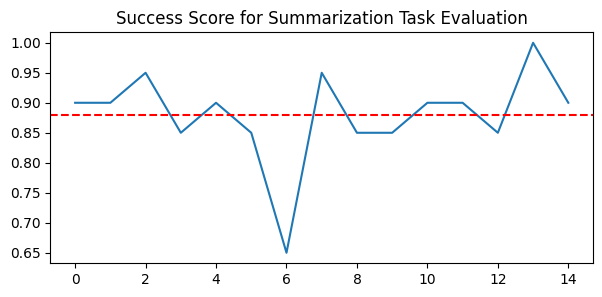

In [16]:
# Plot the success score as line chart with an average line
plt = df['success_score'].plot(kind='line', figsize=(7, 3), title="Success Score for Summarization Task Evaluation")
plt.axhline(y=df['success_score'].mean(), color='r', linestyle='--')

### VerifierAgent

VerifierAgent ensures the criteria used to evaluate a utility are effective for the end-user, maintaining both robustness and high discriminative power.

**Input:** The input to the VerifierAgent will be the `CriticAgent` and `QuantifierAgent`, that will be executed N number of times. Also an additional input will be the `SummarizedCriteriaAgent` which will be used to summarize the criteria.

**Output:** The output of the VerifierAgent will be the `final_criteria=List<Criteria>` which will be used for the evaluation.

[Algorithm 1 VerifierAgent](https://arxiv.org/pdf/2405.02178)

**Note:** In the research the recommended values are `N=50` and `E=18`. However, for this demonstration we will use `N=5`, `E=4` and `S=5`.

In [17]:
# Step 1: First let's take the sample of the data
df = df.head(5)
print("Shape of the dataframe after taking only 5 rows: ", df.shape)

Shape of the dataframe after taking only 5 rows:  (5, 8)


In [18]:
# Step 2: Run CriticAgent with 10 seed and get the summarized criteria
summarized_criteria = await generate_summarized_criteria_multiple_seeds(
    task=summarization_task,
    model_client=az_openai_model_client,
    max_round=2,
    additional_instructions="Make the output as list of JSON objects.",
    seed=5
)
summarized_criteria


---------- user ----------
Task: Summarization of the news article.
        Task description: Given any news context, the system needs to generate a summary as concisely and accurately as possible.
        Task successful example: {'Question': 'Generate a summary of the news article, given in the context. The summary should be concise and informative.', 'Context': "\nCarlos Tevez has been told to terminate his contract with Juventus to complete a return to his former club Boca Juniors in Argentina. \nThe former Manchester City striker's deal with the Serie A champions does not expire until the end of next season but he has reportedly told the club he wishes to leave this summer. \nBoca have confirmed they are close to completing a deal for the 31-year-old, but club president Daniel Angelici has stressed that Tevez must terminate his contract with the Italians first.\nCarlos Tevez has shocked Juventus by suggesting he wants to leave the club this summer .\nTevez is on course to win a se

---------- Summary ----------
Number of messages: 2
Finish reason: Maximum number of messages 2 reached, current message count: 2
Total prompt tokens: 1235
Total completion tokens: 363
Duration: 10.95 seconds
---------- critic ----------
[
{
"name": "Accuracy",
"description": "The generated summary should accurately represent the main points of the news article. It should not include false information or significant omissions.",
"accepted_values": ["Highly accurate", "Mostly accurate", "Somewhat accurate", "Not accurate"]
},
{
"name": "Comprehensiveness",
"description": "The summary should cover all key information and essential details presented in the news article.",
"accepted_values": ["Comprehensive", "Slightly incomplete", "Mostly incomplete", "Not comprehensive"]
},
{
"name": "Conciseness",
"description": "The summary should communicate the information in the shortest possible length without losing key details.",
"accepted_values": ["Highly concise", "Mostly concise", "Somewhat c

[Criterion(name='Relevance', description='The level of relevance of the summary content to the main themes and key points of the original information.', accepted_values=['Highly relevant', 'Relevant', 'Somewhat relevant', 'Not relevant'], sub_criteria=[]),
 Criterion(name='Completeness', description='Degree to which the summary provides a complete representation of all significant information from the original text.', accepted_values=['Fully complete', 'Mostly complete', 'Somewhat complete', 'Incomplete'], sub_criteria=[]),
 Criterion(name='Accuracy', description='The extent to which the summary reflects the details, facts, and information from the original text accurately.', accepted_values=['Highly accurate', 'Accurate', 'Somewhat accurate', 'Not accurate'], sub_criteria=[]),
 Criterion(name='Brevity', description='The conciseness of the summarization while ensuring the original intent is maintained.', accepted_values=['Highly succinct', 'Succinct', 'Somewhat succinct', 'Verbose'], s

In [19]:
# Step 2: Run QuantifierAgent with seeds 4 for all samples
quantified_criteria_multiple_seeds = []
for index, row in df.iterrows():
    quantified_criteria = await quantify_criteria_multiple_seeds(
        model_client=az_openai_model_client,
        criteria=summarized_criteria,
        task=summarization_task,
        test_case=row['test_case'],
        seeds=4
    )
    quantified_criteria_multiple_seeds.append(quantified_criteria)

In [20]:
# Step 3: Run verifier to verify the quantified result and create the final criteria, that can be used for the evaluation
verifier = Verify(
    summarized_criteria=summarized_criteria,
    sampled_quantifications=quantified_criteria_multiple_seeds,
    logger=logging.getLogger()
)
final_criteria = verifier.verify(threshold=0.05)
final_criteria

[Criterion(name='Relevance', description='The level of relevance of the summary content to the main themes and key points of the original information.', accepted_values=['Highly relevant', 'Relevant', 'Somewhat relevant', 'Not relevant'], sub_criteria=[]),
 Criterion(name='Accuracy', description='The extent to which the summary reflects the details, facts, and information from the original text accurately.', accepted_values=['Highly accurate', 'Accurate', 'Somewhat accurate', 'Not accurate'], sub_criteria=[]),
 Criterion(name='Clarity', description='The ease of understanding the content of the summary. It should not require additional context.', accepted_values=['Highly clear', 'Clear', 'Somewhat clear', 'Unclear'], sub_criteria=[]),
 Criterion(name='Coherence', description='The level of logical consistency and flow in the summary. The ideas should smoothly transition between points.', accepted_values=['Highly coherent', 'Coherent', 'Somewhat coherent', 'Not coherent'], sub_criteria=[]

In [21]:
# Let's have at summarized criteria
summarized_criteria

[Criterion(name='Relevance', description='The level of relevance of the summary content to the main themes and key points of the original information.', accepted_values=['Highly relevant', 'Relevant', 'Somewhat relevant', 'Not relevant'], sub_criteria=[]),
 Criterion(name='Completeness', description='Degree to which the summary provides a complete representation of all significant information from the original text.', accepted_values=['Fully complete', 'Mostly complete', 'Somewhat complete', 'Incomplete'], sub_criteria=[]),
 Criterion(name='Accuracy', description='The extent to which the summary reflects the details, facts, and information from the original text accurately.', accepted_values=['Highly accurate', 'Accurate', 'Somewhat accurate', 'Not accurate'], sub_criteria=[]),
 Criterion(name='Brevity', description='The conciseness of the summarization while ensuring the original intent is maintained.', accepted_values=['Highly succinct', 'Succinct', 'Somewhat succinct', 'Verbose'], s

In [22]:
# Let's have a look at initial criteria
critic_agent_output_criteria

[Criterion(name='Conciseness', description='The summary should be brief and to-the-point, clearly stating key details from the news context given, without unnecessary details or redundancy.', accepted_values=['Exceptional', 'Good', 'Adequate', 'Poor', 'Extremely poor'], sub_criteria=[]),
 Criterion(name='Accuracy', description='The summary should accurately represent the events, incidents, or points discussed in the news content. There must be no distortion, misinterpretation, or fabrication of facts.', accepted_values=['Exceptional', 'Good', 'Adequate', 'Poor', 'Extremely poor'], sub_criteria=[]),
 Criterion(name='Clarity', description='The summary should be clearly written and easy to understand. The language should be simple, coherent and there should be a logical flow of information', accepted_values=['Exceptional', 'Good', 'Adequate', 'Poor', 'Extremely poor'], sub_criteria=[]),
 Criterion(name='Completeness', description='The summary should capture all the main points of the arti

## Summary

In this notebook, we have demonstrated how the `AgentEval` framework can be used to evaluate the summarization task. We have used the `CriticAgent`, `QuantifierAgent`, `Multi-dimensional Task Utility`, and `VerifierAgent` to perform the evaluation. The results of the evaluation can be used to compare different applications or versions of the same application.

The following are the few key points to note:

- `AgentEval` a comprehensive framework designed to perform deep evaluations on the LLM-powered applications using agentic approach.
- The evaluation criteria can be suggested by the `CriticAgent` and can be further enhanced by Subject Matter Experts (SMEs).
- The constant drift in the evaluation criteria can be handled by the `VerifierAgent` to ensure the robustness and high discriminative power of the evaluation.
- An additional multi-dimensional task utility to enhance the evaluation with combination of user metrics (ex. user feedback or success score) and quantified results.
- Though the `AgentEval` framework is the outcome of research done for `Task with Defined Success`, it can be used for `Task with not clearly defined success` as well, like *summarization*.
